In [12]:
%matplotlib inline
#%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
#from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2num, num2date
from load_gridded_data import read_gridded_data_CMIP5_model
from gridAvg import gridAvg
import wd

In [13]:
# Load various model output and interpolate to CCSM4 resolution

# CHANGE THIS TO USE THE SAME SORT OF STRUCTURE THAT dd is!

from scipy import interpolate
import gridAvg

data_dir = '/Users/dan/Desktop/CCSM4_ctrl/'
data_files = ['HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc',
              'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
              'MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc']
model_names = ['HadCM3','CCSM4','MPI-ESM']
data_vars = {'tas_sfc_Amon':0}

outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
time = np.arange(850,1851)

ad = []

Ldf = len(data_files)

for ii in np.arange(Ldf):
#for ii in np.array([1]):
    
    data_file = data_files[ii]
    ny = 1000
    dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
    dd['model_name'] = model_names[ii]

    if ii==0:
        dd['datam'] = np.reshape(dd['tas_sfc_Amon']['value'][:ny,:,:],[ny,-1]).transpose()
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
        # Kludge for now
        #dd['datam'] = dd['datam'].transpose()
        #dd['data'] = dd['data'].transpose()

    # If not the model whose grid we're using, interpolate to that grid.
    if ii!=0:
        x    = dd['tas_sfc_Amon']['lon']
        y    = dd['tas_sfc_Amon']['lat']
#        xx, yy = np.meshgrid(x,y)
        xnew = ad[0]['tas_sfc_Amon']['lon']
        ynew = ad[0]['tas_sfc_Amon']['lat']
        umhr = np.zeros(ad[0]['data'].shape)

        for jj in np.arange(ny):
            f = scipy.interpolate.RectBivariateSpline(y,x,dd['tas_sfc_Amon']['value'][jj,:,:].reshape(len(y),len(x)))
            umhr[:,jj] = f(ynew, xnew).ravel()

            
# Made some changes to get the dimensions consistent but haven't checked that anomalies make sense, so could be an error here!            
            
        dd['datam'] = umhr
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
        dd['tas_sfc_Amon']['lat'] = ad[0]['tas_sfc_Amon']['lat']
        dd['tas_sfc_Amon']['lon'] = ad[0]['tas_sfc_Amon']['lon']

    ad.append(dd)



Reading file:  /Users/dan/Desktop/CCSM4_ctrl//HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc
(12012, 73, 96)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= -3.075072e-07  , std-dev= 1.996391
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= -2.700413205941557e-07  , std-dev= 0.8439147355739832
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc
(12000, 96, 192)
Anomalies provided as the prior: Removing 

In [14]:
## Make a gridded average of normalized proxy data to use as a mask on the CCSM4 output
proxy_pandas_metafile = 'Pages2k_Metadata.df.pckl'
proxy_pandas_datafile = 'Pages2k_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# necessary to index this as I'd like. not sure why...
proxy_data.index=proxy_data.index.astype('float64')
proxy_data = proxy_data.astype('float64')

proxy_data = proxy_data[0:2011]

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['PAGES_ID']
proxy_meta=proxy_meta.rename(columns = {'PAGES_ID':'NCDC_ID'})

# Replace all proxy types with a placeholder for now

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_data = proxy_data.loc[:,proxy_meta.index]

# Remove one record that has a range of lat-lon values
proxy_data = proxy_data.drop('Eur_11',1)
proxy_meta = proxy_meta.drop('Eur_11',0)

proxy_data = proxy_data.dropna(1,'all')
proxy_meta = proxy_meta.loc[proxy_data.columns]

proxy_meta.loc[:,'Lat_N'] = proxy_meta.loc[:,'Lat_N'].astype('float64')
proxy_meta.loc[:,'Lon_E'] = proxy_meta.loc[:,'Lon_E'].astype('float64')

import gridAvg
reload( gridAvg )
from gridAvg import gridAvg
# For some reason lon goes from 0 to 359. but lat goes from -90 to 90. I'm treating it instead like it's going from -90 to 89...
xRes = 360. / len(ad[0]['tas_sfc_Amon']['lon'])
yRes = 180. / (len(ad[0]['tas_sfc_Amon']['lat']))

gridded, pmg, lat_g,lon_g = gridAvg(proxy_meta,proxy_data,xRes,yRes)

# Make a mask from the data
dmask = (np.nansum(gridded,0)!=0)

/Users/dan/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
gridAvg.py:46: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  pmg.set_value(index,'lat_ind',lat_ind-1)
gridAvg.py:47: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  pmg.set_value(index,'lon_ind',lon_ind-1)


In [14]:
# Load the comparison object so I don't have to recompute

cd = np.load('compare1.npy');

In [180]:
# Compare what happens for various truth-prior pairs

import wd; reload(wd)

# Array of dictionaries containing the different comparisons
cd = []

# Set proxy locations equal to the PAGES2k network sites. Since there is no observational noise,
# having additional obs makes no difference, so just one per gridbox with any number of proxies
MASK  = dmask
L = np.size(dmask)

# Make the H (data) matrix using MASK
H = np.eye(L)[np.ndarray.flatten(MASK,'C'),:]


rpt_p2k = np.zeros([Ldf,Ldf,L,1000])
rpt_all = np.zeros([Ldf,Ldf,L,1000])

counter = 0

for ii in np.arange(len(data_files)):

    prior = ad[ii]['data']
    #hbhi = scipy.linalg.pinv(np.linalg.multi_dot([H,prior,prior.T,H.T]))
    #bi = scipy.linalg.pinv(np.linalg.multi_dot([prior,prior.T]))

    hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

    # For a complete observing system, it's BB^{-1}. I want to save this i.t.o. its factors. 
    # Probably easiest to do with SVD. 
    # Just UU.T
    u = np.linalg.svd(prior,full_matrices=False)[0]

    for jj in np.arange(len(data_files)):
        #if ii==jj:
        #    continue

        truth = ad[jj]['data']

        # Filtered truth ensemble using PAGES2k data distribution
        fp = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,truth])
        # Filtered truth ensemble using complete data distribution
        fc = np.linalg.multi_dot([u,u.T,truth])

        lon_m,lat_m = np.meshgrid(ad[0]['tas_sfc_Amon']['lon'],ad[0]['tas_sfc_Amon']['lat'])
        coswts = np.sqrt(np.cos(lat_m.ravel()*np.pi/180))
        
        # Eigenvectors of the nullspace uncertainty
        ufp,sfp,tmp = np.linalg.svd(np.tile(coswts,(1000,1)).T*(truth-fp),full_matrices=False)
        ufc,sfc,tmp = np.linalg.svd(np.tile(coswts,(1000,1)).T*(truth-fc),full_matrices=False)
        
#        ufpp = np.tile(coswts,(1000,1)).T*(ufp.T/np.std(ufp,1)).T

        #ufpp = np.tile(coswts,(1000,1)).T*ufp
#        ufpp = ufpp.T/np.std(ufp,1).T

        #ufpp = (ufp.T/np.std(ufp,1)).T

        
        # Store this information in a dictionary
        c = {}
        c['Prior'] = model_names[ii]
        c['Pind'] = ii
        c['Truth'] = model_names[jj]
        c['Tind'] = jj
        c['Filtered truth ensemble using PAGES2k'] = fp
        c['Filtered truth ensemble using complete obs'] = fc
        c['Eigenvectors of nullspace unc using PAGES2k'] = ufp
        c['Eigenvectors of nullspace unc using complete obs'] = ufc
        c['Eigenvalues of nullspace unc using PAGES2k'] = sfp
        c['Eigenvalues of nullspace unc using complete obs'] = sfc
        
        #wd.plotMap_nl(lon_g,lat_g,sfp[0]*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs
        cd.append(c)
        

In [ ]:
# Make some plots!
fig1 = plt.figure(figsize=(8,6))
fig2 = plt.figure(figsize=(8,6))
fig3 = plt.figure(figsize=(8,6))
fig4 = plt.figure(figsize=(8,6))

for ii in np.arange(len(cd)):
    pname = cd[ii]['Prior']
    tname = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']
    
    ax1 = fig1.add_subplot(Ldf, Ldf, ii+1)
    wd.plotMap_nl(lon_g,lat_g,sfp[0]**.5*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')
    ax1.set_title('test')

    
    ax1 = fig2.add_subplot(Ldf, Ldf, ii+1)
    wd.plotMap_nl(lon_g,lat_g,sfc[0]**.5*ufc[:,0].reshape(len(lat_g),len(lon_g)),'')



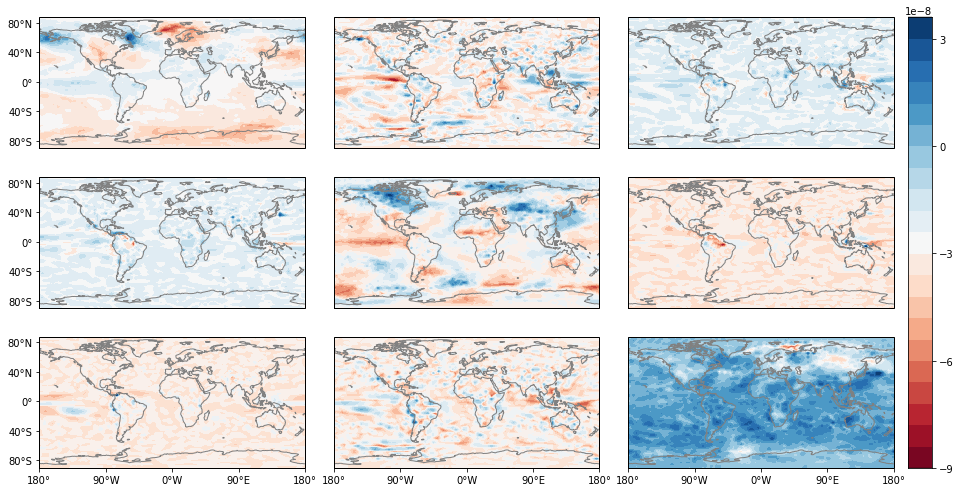

In [226]:
# GOOD ONE FOR NOW, LEAVE AS EXAMPLE
# Plot leading eigenvector of uncertainty

# index of eigenvector
evecn = 0;

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid


#def main():
projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.4,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior']
    tname = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    pldat = sfp[evecn]**.5*ufp[:,evecn].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = add_cyclic_point(pldat, coord=lon_g, axis=1)


    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    p = ax.contourf(wrap_lon,lat_g,wrap_data,20,
                    transform=projection,
                    cmap='RdBu'
                    )
    
    

axgr.cbar_axes[0].colorbar(p)

plt.show()



In [ ]:
# Plot leading eigenvector of uncertainty

# index of eigenvector
evecn = 0;

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm


#def main():
projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.6,
                cbar_location='right',
               cbar_mode='each',
#                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior']
    tname = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    pldat = sfp[evecn]**.5*ufp[:,evecn].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = add_cyclic_point(pldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    max
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-19.5,19.5,.1),
                    transform=projection,
                    extend='both',
                    cmap='RdBu_r'
                    )
    axgr.cbar_axes[ii].colorbar(p)
    plt.title(pname+tname)
    p.set_clim([-1.2,1.2])
#    plt.colorbar()
#    plt.clim(-1.5,1.5)
    
    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

    

#cb = axgr.cbar_axes[0].colorbar(p)#,extend='both')
#cb.cmap.set_under('yellow')
#cb.cbar_axis

plt.show()



<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

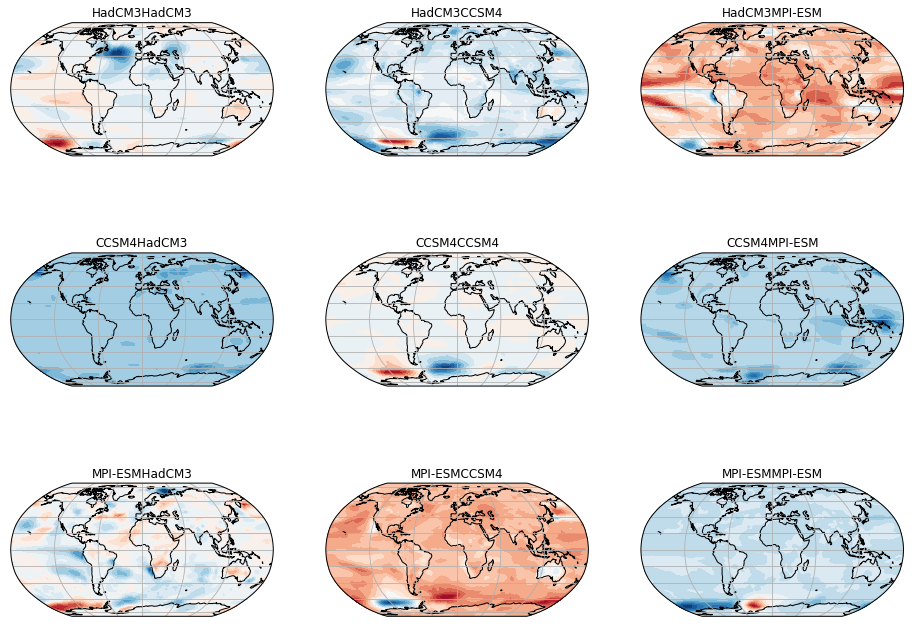

In [197]:
# Plot leading eigenvector of uncertainty

# index of eigenvector
evecn = 0;

fig1 = plt.figure(figsize=(8,6))
fig2 = plt.figure(figsize=(8,6))
fig3 = plt.figure(figsize=(8,6))
fig4 = plt.figure(figsize=(8,6))

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid


#def main():

fig = plt.figure(figsize=(16,12))

for ii in np.arange(len(cd)):

    pname = cd[ii]['Prior']
    tname = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']

    ax = plt.subplot(Ldf, Ldf, ii+1,projection=ccrs.Robinson())
    
    pldat = sfp[evecn]**.5*ufp[:,evecn].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = add_cyclic_point(pldat, coord=lon_g, axis=1)

    ax.set_global()

    plt.contourf(wrap_lon,lat_g,wrap_data,20,
                    transform=projection,
                    cmap='RdBu'
                    )

    ax.coastlines()
    ax.gridlines()
    plt.title(pname+tname)

    
    

    
    
    

plt.show()

